In [1]:
#Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

import string
import re
import keras

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , LSTM , Embedding
from keras.models import Sequential
from keras.callbacks import EarlyStopping

#import warnings warnings.filterwarnings('ignore')

import pickle

In [3]:
data = pd.read_csv("/Users/binitashrestha/Documents/processed_reviews_split_RESIT_minimal.csv")
data.head(2)
#DATA OVERVIEW

,review_id,text,verified,review_score,product_category
0,product_review_000000,OMG this is sooo good.. Very Good!!!,True,5.0,prime_pantry
1,product_review_000001,This soap smells pretty good and it seems to w...,True,4.0,prime_pantry


In [4]:
#LENGTH OF DATASET
data.shape

(28153, 5)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28153 entries, 0 to 28152
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   review_id         28153 non-null  object 
 1   text              28132 non-null  object 
 2   verified          28028 non-null  object 
 3   review_score      28153 non-null  float64
 4   product_category  27377 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.1+ MB


In [8]:
#####DATA CLEANING AND HANDLING MISSING VALUES
#####Check null values
data.isna().sum().to_frame(name='# of missing values')

,# of missing values
review_id,0
text,21
verified,125
review_score,0
product_category,776


In [9]:
####REMOVE ALL ROWS WITH NULL VALUES
total_rows =  data.shape[0]
data.dropna(how='any',inplace=True)
remaining_rows= data.shape[0]

removed_rows = total_rows-remaining_rows
print("No. of rows removed :", removed_rows)

print(f"\nPercentage of data removed:{np.round((removed_rows/total_rows)*100,2)}%")
print(f"Percentage of data remaining:{np.round((remaining_rows/total_rows)*100,2)}%")

No. of rows removed : 920

Percentage of data removed:3.27%
Percentage of data remaining:96.73%


In [10]:
#####REMOVE ALL DUPLICATE ROWS
a =  data.shape[0]
data.drop_duplicates(inplace=True, subset=['review_score','text'])
b = data.shape[0]

print("No. of rows removed :", a-b)

print(f"\nPercentage of data removed: {np.round(((a-b)/total_rows)*100,2)}%")
print(f"Percentage of data remaining: {np.round((b/total_rows)*100,2)}%")

No. of rows removed : 821

Percentage of data removed: 2.92%
Percentage of data remaining: 93.82%


In [11]:
data["text"].isnull().sum()
data["review_id"].isnull().sum()

0

In [ ]:
#DATA CLEANING
#HANDLING MISSING VALUES

In [12]:
# Check null values
data.isna().sum().to_frame(name='# of missing values')

,# of missing values
review_id,0
text,0
verified,0
review_score,0
product_category,0


### Remove rows which are having null values

In [14]:
#Data Cleaning
data['excluded'] = False
data['reason_for_exclusion'] = ""

In [15]:
#Remove NAN text
null_text = data[data['text'].isnull()]
data.loc[null_text.index,'excluded'] = True
data.loc[null_text.index,'reason_for_exclusion'] = "missing_value_or_label"

In [16]:
#Review Score Invalid
invalid_score = data[data['review_score'] < 0 ]
data.loc[invalid_score.index,'excluded'] = True
data.loc[invalid_score.index,'reason_for_exclusion'] = "invalid"

In [17]:
#Get valid set of rows
remaining_data = data[data['excluded']==False]

In [18]:
# Check null values
data.isna().sum().to_frame(name='# of missing values')

,# of missing values
review_id,0
text,0
verified,0
review_score,0
product_category,0
excluded,0
reason_for_exclusion,0


In [19]:
data.shape

(26412, 7)

In [20]:
remaining_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25643 entries, 0 to 28152
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   review_id             25643 non-null  object 
 1   text                  25643 non-null  object 
 2   verified              25643 non-null  object 
 3   review_score          25643 non-null  float64
 4   product_category      25643 non-null  object 
 5   excluded              25643 non-null  bool   
 6   reason_for_exclusion  25643 non-null  object 
dtypes: bool(1), float64(1), object(5)
memory usage: 1.4+ MB


In [21]:

#stopwords
total_stopwords = set(stopwords.words('english'))

# subtract negative stop words like no, not, don't etc.. from total_stopwords
negative_stop_words = set(word for word in total_stopwords 
                          if "n't" in word or 'no' in word)

final_stopwords = total_stopwords - negative_stop_words

# 
final_stopwords.add("one")
print(final_stopwords)

{'hers', 'only', 'through', 'them', 'my', 'most', 'o', 'so', 'a', 'by', 'what', 't', 'does', 'we', 'how', "should've", 'and', 'other', 've', 'ain', 'some', 'ma', 'your', 'won', 'being', 'doing', 'm', 'above', 'don', 'down', 'having', 'out', 'haven', 'such', 'shouldn', 'because', 'again', 'been', 'had', 'our', 'can', 'during', 'didn', 'mightn', 'until', 'am', 'further', 'too', 'or', 'should', 'these', 'an', 'in', 'they', 'you', 'was', 'who', 'it', 'that', 'with', 'on', 'did', 'between', 'from', 'will', 'before', "it's", 'd', 'all', 'aren', 'own', 'over', 'its', 'he', 'which', 'mustn', 'at', 'off', "that'll", 'weren', 'myself', 'wouldn', 'ours', 'after', 'for', 'yourselves', 'll', 'hasn', "you've", 'as', 'were', 'whom', 's', 'herself', 'below', 'yourself', 'once', 'here', 'do', 'himself', 'but', 'y', 'yours', 'have', 'each', 'very', 'just', 'me', 'has', 'doesn', 'itself', 'if', 'ourselves', 'than', 'under', 'when', 'both', 'why', 'few', 'are', 'where', 'any', 'more', 'their', 'up', 'agai

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26412 entries, 0 to 28152
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   review_id             26412 non-null  object 
 1   text                  26412 non-null  object 
 2   verified              26412 non-null  object 
 3   review_score          26412 non-null  float64
 4   product_category      26412 non-null  object 
 5   excluded              26412 non-null  bool   
 6   reason_for_exclusion  26412 non-null  object 
dtypes: bool(1), float64(1), object(5)
memory usage: 2.4+ MB


In [23]:
duplicates = remaining_data[remaining_data.duplicated(['text'],keep=False)]

for text,obj_group in remaining_data.groupby('text'):
    obj = obj_group.to_dict('records')
    if len(obj) == 1:
        continue
    review_score = obj[0]['review_score']
    for each_obj in obj[1:]:
        if each_obj['review_score'] != review_score:
            print(obj[0]['review_score'],obj[0]['review_id'])
            print(text[:10],len(obj),each_obj['review_id'])
            break

5.0 product_review_007973
:).  2 product_review_008890
4.0 product_review_015453
Always goo 2 product_review_023043
4.0 product_review_010217
Arrived in 2 product_review_015205
3.0 product_review_002053
Came on ti 2 product_review_008681
5.0 product_review_000563
GREAT WILL 2 product_review_005280
5.0 product_review_009310
Good Produ 2 product_review_015621
5.0 product_review_016841
Good Value 2 product_review_017315
5.0 product_review_006214
Good price 2 product_review_020792
4.0 product_review_004659
Good produ 2 product_review_013177
5.0 product_review_026101
Good produ 2 product_review_026936
4.0 product_review_001697
Good produ 3 product_review_009663
5.0 product_review_012601
Good stuff 2 product_review_026616
4.0 product_review_014023
Good value 2 product_review_018519
4.0 product_review_014266
Good value 2 product_review_014737
1.0 product_review_002183
Good.  3 product_review_013475
3.0 product_review_009257
Good..  2 product_review_027290
5.0 product_review_014160
Great, del 

In [24]:
len(duplicates)

141

In [25]:
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download("stopwords")
stop_words=stopwords.words("english")
new_stopping_words = stop_words[:len(stop_words)-36]
new_stopping_words.remove("not")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/binitashrestha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/binitashrestha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [26]:
def remove_punc(data):
    new_text= re.sub("n't",'not', data)
    new_text= re.sub('[^\w\s]','', data)
    return new_text

In [27]:
processed_text= remove_punc(str(data["text"]))
processed_text

'0                     OMG this is sooo good Very Good\n1        This soap smells pretty good and it seems to w\n2        Dont seem to dissolve after quite some time \n3        these zip bags do as they should very good I\n4        What A MessnI recommend making this in a m\n                                                       \n28146    Ive used drugstore body oils and dry oil spra\n28147    Ordered two of the bandaids which we use most\n28149                            healthy tasty side dish \n28151    Dont let the packaging turn you away  Jack B\n28152    I am quite lightskinned and when I was asked \nName text Length 26412 dtype object'

In [28]:
def tokenizze(data):
    newdata= word_tokenize(data)
    return newdata

In [29]:
tokenized_data= tokenizze(processed_text.lower())
tokenized_data

['0',
 'omg',
 'this',
 'is',
 'sooo',
 'good',
 'very',
 'good',
 '1',
 'this',
 'soap',
 'smells',
 'pretty',
 'good',
 'and',
 'it',
 'seems',
 'to',
 'w',
 '2',
 'dont',
 'seem',
 'to',
 'dissolve',
 'after',
 'quite',
 'some',
 'time',
 '3',
 'these',
 'zip',
 'bags',
 'do',
 'as',
 'they',
 'should',
 'very',
 'good',
 'i',
 '4',
 'what',
 'a',
 'messni',
 'recommend',
 'making',
 'this',
 'in',
 'a',
 'm',
 '28146',
 'ive',
 'used',
 'drugstore',
 'body',
 'oils',
 'and',
 'dry',
 'oil',
 'spra',
 '28147',
 'ordered',
 'two',
 'of',
 'the',
 'bandaids',
 'which',
 'we',
 'use',
 'most',
 '28149',
 'healthy',
 'tasty',
 'side',
 'dish',
 '28151',
 'dont',
 'let',
 'the',
 'packaging',
 'turn',
 'you',
 'away',
 'jack',
 'b',
 '28152',
 'i',
 'am',
 'quite',
 'lightskinned',
 'and',
 'when',
 'i',
 'was',
 'asked',
 'name',
 'text',
 'length',
 '26412',
 'dtype',
 'object']

In [30]:
def remove_num(data):
    text_without_num=[w for w in data if w.isalpha()]
    return text_without_num


In [31]:
textwithoutnum = remove_num(tokenized_data)
textwithoutnum

['omg',
 'this',
 'is',
 'sooo',
 'good',
 'very',
 'good',
 'this',
 'soap',
 'smells',
 'pretty',
 'good',
 'and',
 'it',
 'seems',
 'to',
 'w',
 'dont',
 'seem',
 'to',
 'dissolve',
 'after',
 'quite',
 'some',
 'time',
 'these',
 'zip',
 'bags',
 'do',
 'as',
 'they',
 'should',
 'very',
 'good',
 'i',
 'what',
 'a',
 'messni',
 'recommend',
 'making',
 'this',
 'in',
 'a',
 'm',
 'ive',
 'used',
 'drugstore',
 'body',
 'oils',
 'and',
 'dry',
 'oil',
 'spra',
 'ordered',
 'two',
 'of',
 'the',
 'bandaids',
 'which',
 'we',
 'use',
 'most',
 'healthy',
 'tasty',
 'side',
 'dish',
 'dont',
 'let',
 'the',
 'packaging',
 'turn',
 'you',
 'away',
 'jack',
 'b',
 'i',
 'am',
 'quite',
 'lightskinned',
 'and',
 'when',
 'i',
 'was',
 'asked',
 'name',
 'text',
 'length',
 'dtype',
 'object']

In [32]:
#stemming object
stemmer = PorterStemmer()

# ---------------------------------------------
HTMLTAGS = re.compile('<.*?>')
table = str.maketrans(dict.fromkeys(string.punctuation))
remove_digits = str.maketrans('', '', string.digits)
MULTIPLE_WHITESPACE = re.compile(r"\s+")
# ---------------------------------------------

In [51]:
# stopwords
total_stopwords = set(stopwords.words('english'))

# subtract negative stop words like no, not, don't etc.. from total_stopwords
negative_stop_words = set(word for word in total_stopwords 
                          if "n't" in word or 'no' in word)

final_stopwords = total_stopwords - negative_stop_words

# 
final_stopwords.add("one")
print(final_stopwords)

{'hers', 'only', 'through', 'them', 'my', 'most', 'o', 'so', 'a', 'by', 'what', 't', 'does', 'we', 'how', "should've", 'and', 'other', 've', 'ain', 'some', 'ma', 'your', 'won', 'being', 'doing', 'm', 'above', 'don', 'down', 'having', 'out', 'haven', 'such', 'shouldn', 'because', 'again', 'been', 'had', 'our', 'can', 'during', 'didn', 'mightn', 'until', 'am', 'further', 'too', 'or', 'should', 'these', 'an', 'in', 'they', 'you', 'was', 'who', 'it', 'that', 'with', 'on', 'did', 'between', 'from', 'will', 'before', "it's", 'd', 'all', 'aren', 'own', 'over', 'its', 'he', 'which', 'mustn', 'at', 'off', "that'll", 'weren', 'myself', 'wouldn', 'ours', 'after', 'for', 'yourselves', 'll', 'hasn', "you've", 'as', 'were', 'whom', 's', 'herself', 'below', 'yourself', 'once', 'here', 'do', 'himself', 'but', 'y', 'yours', 'have', 'each', 'very', 'just', 'me', 'has', 'doesn', 'itself', 'if', 'ourselves', 'than', 'under', 'when', 'both', 'why', 'few', 'are', 'where', 'any', 'more', 'their', 'up', 'agai

In [52]:
data["text"].isnull().sum()
data["review_id"].isnull().sum()

0

In [33]:
def preprocessor(review):
    # remove html tags
    review = HTMLTAGS.sub(r'', review)

    # remove puncutuation
    review = review.translate(table)
    
    # remove digits
    review = review.translate(remove_digits)
    
    # lower case all letters
    review = review.lower()
    
    # replace multiple white spaces with single space
    review = MULTIPLE_WHITESPACE.sub(" ", review).strip()
    
    # remove stop words
    review = [word for word in review.split()
              if word not in final_stopwords]
    
    # stemming
    review = ' '.join([stemmer.stem(word) for word in review])
    
    return review

In [34]:
print("Before preprocessing : ")
data.text.iloc[6]

Before preprocessing : 


'Love the gold peak teas!! I am a tea snob and this has been the only brand that I will drink. I purchased these for my son who is also an iced tea lover, but he lives in the dorm and I know that he would appreciate a good glass of iced tea after working outside in the sun all day. I would highly recommend this brand if you love iced tea, but hate the hassle of brewing it yourself.. Love the gold peak teas'

In [35]:

# apply preprocessing function

data.text = data.text.apply(preprocessor) 
print("After preprocessing : ")
data.text.iloc[6]

After preprocessing : 


'love gold peak tea tea snob brand drink purchas son also ice tea lover live dorm know would appreci good glass ice tea work outsid sun day would highli recommend brand love ice tea hate hassl brew love gold peak tea'

### Create target column using Score

In [36]:
############recode product catagory to 1 and 0
#########
###########
################

/Users/binitashrestha/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'review_score')

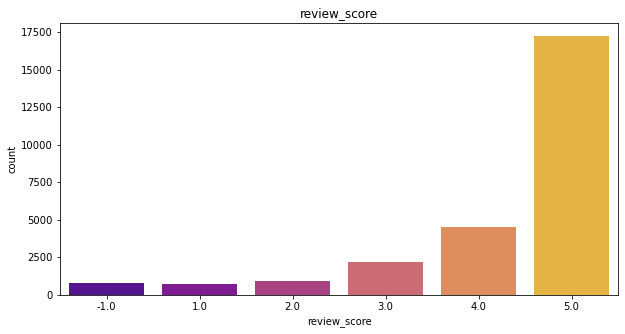

In [37]:
import seaborn as sns
sns.countplot(data['review_score'], palette="plasma")
fig = plt.gcf()
fig.set_size_inches(10,5)
plt.title('review_score')

In [40]:
##breaking scores: Score>3: psotive, ==3: Neutral, <3: Negative

def create_target(x):
    
    return "Positive" if x>3 else "Negative" if x<3 else "Neutral"

data.loc[:, 'target'] = data.review_score.apply(create_target)

In [42]:
data["review_score"].value_counts()

 5.0    17256
 4.0     4520
 3.0     2219
 2.0      910
-1.0      769
 1.0      738
Name: review_score, dtype: int64

In [44]:
#1. number of stars associated with review score, target column 
data[['review_score', 'target']].sample(5)

,review_score,target
22155,5.0,Positive
15681,5.0,Positive
7185,-1.0,Negative
9677,4.0,Positive
13718,5.0,Positive


In [46]:
X = data.text
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    
    X, y, test_size=0.20, random_state=1, stratify=y)

In [47]:
X_train.shape, X_test.shape

((21129,), (5283,))

In [48]:
rating_data = pd.DataFrame(data, columns=['review_score', 'target'])
print(rating_data.shape)
rating_data.head()

(26412, 2)


,review_score,target
0,5.0,Positive
1,4.0,Positive
2,1.0,Negative
3,5.0,Positive
4,2.0,Negative


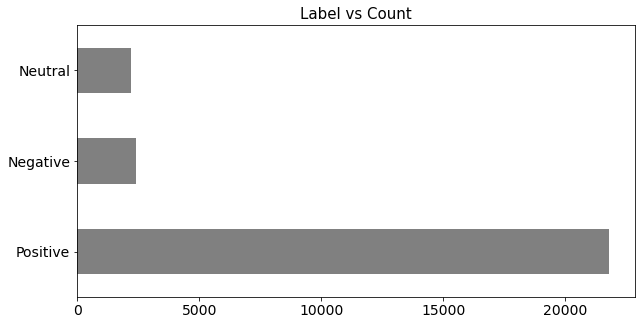

In [49]:
fig, ax = plt.subplots(figsize=(10, 5))
vc = data.target.value_counts()
vc.plot.barh(color="grey",fontsize=14,ax=ax)
ax.set_title("Label vs Count", fontsize=15)
plt.show()

In [53]:
#Bag of Words Vectorizer
bow_vectorizer = CountVectorizer(max_features=10000)
bow_vectorizer.fit(X_train)

# transform
bow_X_train = bow_vectorizer.transform(X_train)
bow_X_test = bow_vectorizer.transform(X_test)

In [54]:
#TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(X_train)

# transform
tfidf_X_train = tfidf_vectorizer.transform(X_train)
tfidf_X_test = tfidf_vectorizer.transform(X_test)

In [55]:
#LABEL ENCODING
labelEncoder = LabelEncoder()

y_train = labelEncoder.fit_transform(y_train)
y_test = labelEncoder.transform(y_test)

labels = labelEncoder.classes_.tolist()
print(labels) # index-> class

['Negative', 'Neutral', 'Positive']


In [57]:
###MODEL TRAINING
def train_and_eval(model, trainX, trainY, testX, testY):

    # training
    _ = model.fit(trainX, trainY)

    # predictions
    y_preds_train = model.predict(trainX)
    y_preds_test = model.predict(testX)

    # evaluation
    print()
    print(model)
    print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
    print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")
    print('\n',40*'-')

In [58]:
##LOGISTIC REGRESSION WITH BOW
# Hyperparameters
C = [0.001, 0.01, 0.1, 1, 10]

for c in C: 
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500, random_state=1)
    
    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)


LogisticRegression(C=0.001, max_iter=500, random_state=1)
Train accuracy score : 0.8265417199110228
Test accuracy score : 0.8237743706227523

 ----------------------------------------

LogisticRegression(C=0.01, max_iter=500, random_state=1)
Train accuracy score : 0.8464669411709026
Test accuracy score : 0.8288851031610828

 ----------------------------------------

LogisticRegression(C=0.1, max_iter=500, random_state=1)
Train accuracy score : 0.8824364617350561
Test accuracy score : 0.8364565587734242

 ----------------------------------------

LogisticRegression(C=1, max_iter=500, random_state=1)
Train accuracy score : 0.9215769795068389
Test accuracy score : 0.8264243800870718

 ----------------------------------------

LogisticRegression(C=10, max_iter=500, random_state=1)
Train accuracy score : 0.9459037342041744
Test accuracy score : 0.7978421351504826

 ----------------------------------------


/Users/binitashrestha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [60]:
##NAIVE BAYES CLASSIFIER WITH BOW
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas: 
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)


MultinomialNB(alpha=0)
Train accuracy score : 0.8925647214728573
Test accuracy score : 0.8182850653038046

 ----------------------------------------

MultinomialNB(alpha=0.2)
Train accuracy score : 0.8752425576222254
Test accuracy score : 0.8158243422297937

 ----------------------------------------

MultinomialNB(alpha=0.6)
Train accuracy score : 0.8720242320980642
Test accuracy score : 0.8220707931099754

 ----------------------------------------

MultinomialNB(alpha=0.8)
Train accuracy score : 0.8717402621988736
Test accuracy score : 0.8271815256483059

 ----------------------------------------

MultinomialNB(alpha=1)
Train accuracy score : 0.8718349188319372
Test accuracy score : 0.8296422487223168

 ----------------------------------------


/Users/binitashrestha/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


In [61]:
##LOGISTIC REGRESION WITH TF-IDF
# Hyperparameters
C = [0.001, 0.01, 0.1, 1, 10]

for c in C: 
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500, random_state=1)
    
    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


LogisticRegression(C=0.001, max_iter=500, random_state=1)
Train accuracy score : 0.8244592739836244
Test accuracy score : 0.8245315161839863

 ----------------------------------------

LogisticRegression(C=0.01, max_iter=500, random_state=1)
Train accuracy score : 0.8244592739836244
Test accuracy score : 0.8245315161839863

 ----------------------------------------

LogisticRegression(C=0.1, max_iter=500, random_state=1)
Train accuracy score : 0.8310852382980738
Test accuracy score : 0.8292636759416998

 ----------------------------------------

LogisticRegression(C=1, max_iter=500, random_state=1)
Train accuracy score : 0.8725448435799139
Test accuracy score : 0.8425137232632973

 ----------------------------------------

LogisticRegression(C=10, max_iter=500, random_state=1)
Train accuracy score : 0.9238960670168962
Test accuracy score : 0.8271815256483059

 ----------------------------------------


In [62]:
##NAIVE BAYES CLASSIFIER WITH TF-IDF

alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas: 
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


MultinomialNB(alpha=0)
Train accuracy score : 0.8786501964125136
Test accuracy score : 0.8243422297936779

 ----------------------------------------

MultinomialNB(alpha=0.2)
Train accuracy score : 0.848738700364428
Test accuracy score : 0.8269922392579974

 ----------------------------------------

MultinomialNB(alpha=0.6)
Train accuracy score : 0.8293340905863978
Test accuracy score : 0.8256672345258376

 ----------------------------------------

MultinomialNB(alpha=0.8)
Train accuracy score : 0.8272989729755312
Test accuracy score : 0.8254779481355291

 ----------------------------------------

MultinomialNB(alpha=1)
Train accuracy score : 0.8262577500118321
Test accuracy score : 0.8245315161839863

 ----------------------------------------


/Users/binitashrestha/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


In [63]:
##MODEL EVALUATION
def plot_cm(y_true, y_pred):
    plt.figure(figsize=(6,6))
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    
    sns.heatmap(
        cm, annot=True, cmap='Blues', cbar=False, fmt='.2f',
        xticklabels=labels, yticklabels=labels)
    
    return plt.show()

In [65]:
#LOGISTIC REGRESSION WITH C=1 WITH TF-IDF DATA IS BEST MODEL
bmodel = LogisticRegression(C=1, max_iter=500, random_state=1)
bmodel.fit(tfidf_X_train, y_train)

LogisticRegression(C=1, max_iter=500, random_state=1)

In [66]:
# predictions
y_preds_train = bmodel.predict(tfidf_X_train)
y_preds_test = bmodel.predict(tfidf_X_test)

In [67]:
#ACCURACY
print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")

Train accuracy score : 0.8725448435799139
Test accuracy score : 0.8425137232632973


### Confusion Matrix

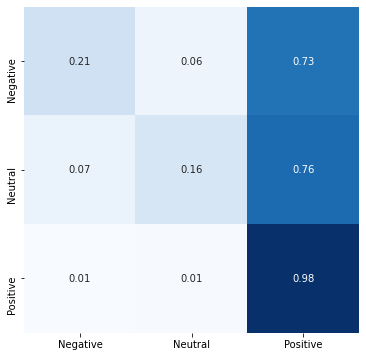

In [69]:
#CONFUSION MATRIX
plot_cm(y_test, y_preds_test)

In [70]:
#SAVE MODEL
with open("transformer.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)
    
with open("model.pkl", "wb") as f:
    pickle.dump(bmodel, f)

In [72]:
#MAKING PREDICTIONS
labels = ['Negative', 'Neutral', 'Positive']
def get_sentiment(review):
    # preprocessing
    x = preprocessor(review)
    
    #vectorization
    x = tfidf_vectorizer.transform([x])
    
    #prediction
    y = int(bmodel.predict(x.reshape(1,-1)))
    return labels[y]

In [74]:
# EXAMPLE
review = "This product is NOT good. I buy this!!"

print(f"This is a {get_sentiment(review)} review!")

This is a Negative review!
